<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [3]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
import os
 
import pandas as pd
import numpy as np

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

# LDA libraries
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

nlp = spacy.load("en_core_web_lg")
df = pd.read_csv('./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip')

# Removed warning that is irrelevant to us and cluters
import warnings

warnings.filterwarnings(
    'ignore',
    'detected Windows; aliasing chunkize to chunkize_serial',
)

unable to import 'smart_open.gcs', disabling that module


In [4]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [5]:
df1 = df[['brand', 'reviews.text']]
df1.head()

,brand,reviews.text
0,Amazonbasics,I order 3 of them and one of the item is bad q...
1,Amazonbasics,Bulk is always the less expensive way to go fo...
2,Amazonbasics,Well they are not Duracell but for the price i...
3,Amazonbasics,Seem to work as well as name brand batteries a...
4,Amazonbasics,These batteries are very long lasting the pric...


In [6]:
def get_lemmas(text):
    
    words = ['batteries','I', 'amazon', 'i',
             'Amazon', 'it', "it's", 'it.', 'the', 'this',]
    STOP_WORDS = nlp.Defaults.stop_words.union(words)
    
    doc = nlp(text)
    
    doc_tokens = []

    lemmas = []
    
    for token in doc:
        if (token.text.lower() not in STOP_WORDS) and ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
#             doc_tokens.append(token.text.lower())

#         if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
#             lemmas.append(token.lemma_)
    
    return lemmas

In [ ]:
# STOP_WORDS = nlp.Defaults.stop_words.union(['batteries','I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this',])

# tokens = []

# for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    
#     doc_tokens = []
    
#     for token in doc: 
#         if token.text.lower() not in STOP_WORDS:
#             doc_tokens.append(token.text.lower())
   
#     tokens.append(doc_tokens)
    
# df['tokens'] = tokens

In [7]:
df1['lemmas'] = df['reviews.text'].apply(get_lemmas)

In [8]:
df1.lemmas.head()

0    [order, 3, item, bad, quality, miss, backup, s...
1                [bulk, expensive, way, product, like]
2                             [Duracell, price, happy]
3                           [work, brand, well, price]
4                           [long, last, price, great]
Name: lemmas, dtype: object

In [9]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [10]:
wc = count(df1['lemmas'])

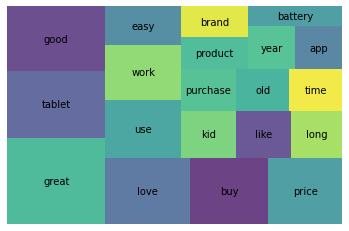

In [11]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [12]:
id2word = corpora.Dictionary(df1.lemmas)

In [13]:
id2word.token2id['battery']

4

In [14]:
id2word[4]

'battery'

In [15]:
len(id2word.keys())

9702

In [16]:
id2word.filter_extremes(no_below=20, no_above=0.98)

In [17]:
len(id2word.keys())

1358

In [18]:
corpus = [id2word.doc2bow(text) for text in df1.lemmas]

In [19]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [21]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f"----------- Topic {id} -----------")
    print(t)

----------- Topic 0 -----------
tablet game love kid great
----------- Topic 1 -----------
tablet screen app size nice
----------- Topic 2 -----------
brand long buy price work
----------- Topic 3 -----------
recommend product great reader excellent
----------- Topic 4 -----------
year old love gift Christmas
----------- Topic 5 -----------
read book Kindle light kindle
----------- Topic 6 -----------
sound like speaker Alexa music
----------- Topic 7 -----------
work long battery life great
----------- Topic 8 -----------
love easy use tablet buy
----------- Topic 9 -----------
good price tablet deal cheap
----------- Topic 10 -----------
case kid child charge buy
----------- Topic 11 -----------
tablet use device app need
----------- Topic 12 -----------
buy money use time week
----------- Topic 13 -----------
buy old year fire kindle
----------- Topic 14 -----------
great price product work value


In [23]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/jeanf/.vscode/extensions/ms-python.python-2020.3.71659/pythonFiles/lib/python/past/types/oldstr.py:23: DeprecationWarning: invalid escape sequence \d
  """


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.192299 -0.126108       1        1  10.949273
0     -0.186875  0.101954       2        1   9.591261
11    -0.068259  0.033466       3        1   8.199540
5     -0.107231 -0.016596       4        1   7.609130
8     -0.219656  0.062488       5        1   6.668314
1     -0.034140  0.088429       6        1   6.522172
12     0.100595 -0.223124       7        1   6.439067
9      0.211992  0.151142       8        1   6.151616
6      0.033006 -0.107776       9        1   6.080059
10    -0.113260 -0.047992      10        1   5.793916
4     -0.180804 -0.031713      11        1   5.786788
7      0.204719 -0.144614      12        1   5.782333
14     0.262143  0.208943      13        1   5.593489
13    -0.112214 -0.132918      14        1   4.934674
3      0.017684  0.184419      15        1   3.898377, topic_info=        Term         Freq        Total Category  logprob  loglift
19     great  9177.000000  9177.000000  Default  30.0000  30.0000
29      good  6578.000000  6578.000000  Default  29.0000  29.0000
16     price  5038.000000  5038.000000  Default  28.0000  28.0000
77      love  5911.000000  5911.000000  Default  27.0000  27.0000
8       work  4469.000000  4469.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
39      look   102.075409   911.130005  Topic15  -4.7019   1.0556
1152  tablet   172.746445  7437.544922  Topic15  -4.1758  -0.5179
1210  Kindle   119.505592  1799.169189  Topic15  -4.5443   0.5329
29      good   155.357437  6578.616699  Topic15  -4.2819  -0.5012
26       buy    95.748917  5786.312988  Topic15  -4.7659  -0.8569

[909 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1231      3  0.683912    $
1231      4  0.004470    $
1231      5  0.002235    $
1231      6  0.151980    $
1231      7  0.002235    $
...     ...       ...  ...
774       2  0.245463   yr
774       5  0.159551   yr
774      10  0.576837   yr
774      11  0.012273   yr
774      14  0.004091   yr

[3436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 12, 6, 9, 2, 13, 10, 7, 11, 5, 8, 15, 14, 4])

In [24]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, df_column, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    warnings.filterwarnings('ignore')
    
    coherence_values = []
    
    tokens = list(df_column)
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = df_column
            model = LdaMulticore(corpus=corpus,
                                 num_topics=num_topics,
                                 id2word=dictionary,
                                 random_state=723812,
                                 workers=8)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [25]:
# Can take a long time to run.
# warnings.filterwarnings(
#     'ignore',
#     'Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.',
# )

# import warnings

# def fxn():
#     warnings.warn("deprecated", DeprecationWarning)

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()

import warnings
warnings.filterwarnings('ignore')

coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        df_column=df1.lemmas, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=40)

In [26]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [27]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-2.427125
1,0,8,-2.480431
2,0,14,-2.443321
3,0,20,-2.500233
4,0,26,-2.467541


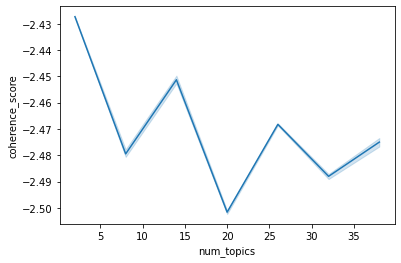

In [28]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [29]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling